In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbr

from scipy.stats.distributions import gamma, gilbrat, gumbel_r
from scipy.stats.distributions import poisson, dlaplace
from scipy.stats import kde, pearsonr, kstest
from statsmodels.api import qqplot_2samples

from scipy.special import psi, polygamma

from scipy.optimize import newton, curve_fit, least_squares, brute

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
%matplotlib inline

dataset = pd.read_csv("/home/rami/hdd/multivariable_analysis/kc_house_data.csv")
print(dataset.shape)

main_variables_labels = ['price', 'sqft_living', 'grade']

dataset = dataset.drop(dataset.loc[dataset.price > 3430000.0].index)
print(dataset.shape)


dataset[main_variables_labels].describe()

(21613, 21)
(21591, 21)


,price,sqft_living,grade
count,2.159100e+04,21591.000000,21591.000000
mean,5.359260e+05,2074.776203,7.652587
std,3.411989e+05,902.586674,1.168029
min,7.500000e+04,290.000000,1.000000
25%,3.210000e+05,1420.000000,7.000000
50%,4.500000e+05,1910.000000,7.000000
75%,6.430010e+05,2550.000000,8.000000
max,3.418800e+06,13540.000000,13.000000


In [43]:
def plot_qq(init_df, df, tf_type):
    
    for label in df.columns:
        
        init_distribution, buckets = np.histogram(init_df[label], density=True)
        its_distribution, buckets = np.histogram(df[label], bins=buckets, density=True)
        
        ks = ks_2samp(its_distribution, init_distribution)
        
        qqplot_2samples(init_df[label], df[label], line='45', xlabel=f'{tf_type} distribution', ylabel='Init distribution')
        plt.title(label + ' KS: s=%f, p=%f' % ks)
        plt.show()

# Price

/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


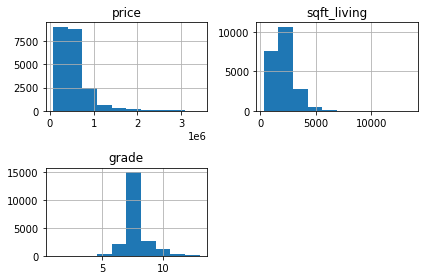

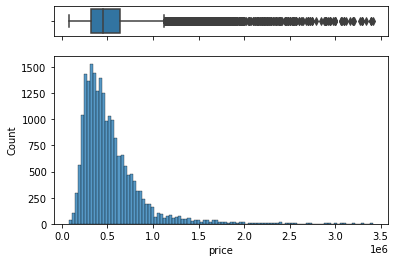

price           2.467258
sqft_living     5.284268
grade          42.926894
dtype: float64
------------------------------
price          217215.240742
sqft_living       392.632695
grade               0.178270
dtype: float64


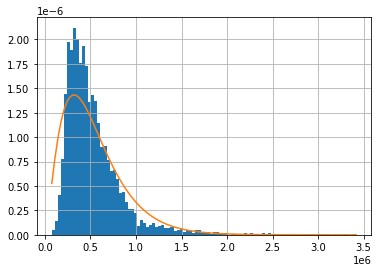

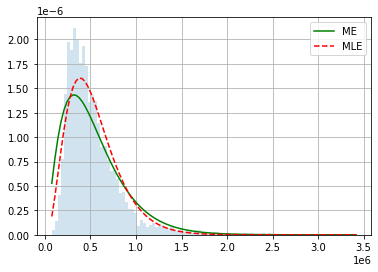

Moments: 5.284267537345997, 392.6326947650373
MLE    : 3.5769686547161217, 6.674370131639555e-06


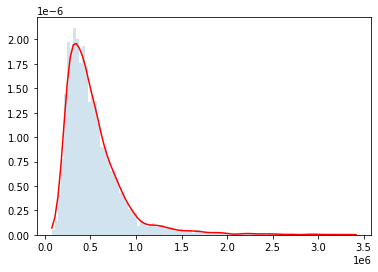

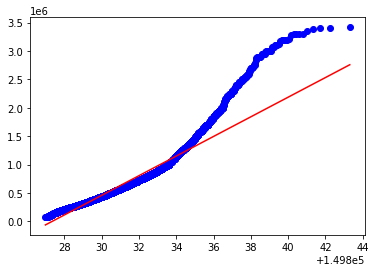

Kalmagorov: Is H1 true? KstestResult(statistic=0.06245519502647323, pvalue=1.1707811257449276e-73)
Pearson: Corr coeff (0.9662270278891475, 1.6135253845463363e-59)


In [44]:
_ = dataset[main_variables_labels].hist()
plt.tight_layout()

# Price

## Gamma

### Box-and-whiskers diagram

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sbr.boxplot(dataset.price, ax=ax_box)
sbr.histplot(data=dataset, x="price", ax=ax_hist, bins=100)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()


### Moments Estimation

alpha = np.mean(dataset[main_variables_labels])**2 / np.var(dataset[main_variables_labels])
beta = np.var(dataset[main_variables_labels]) / np.mean(dataset[main_variables_labels])

print(alpha)
print("-"*30)
print(beta)

_ = dataset.price.hist(density=True, bins=100)
min_val = dataset.price.min()

x = np.linspace(min_val, np.max(dataset.price), 100)
_ = plt.plot(x, gamma.pdf(x, alpha.price, scale=beta.price))
plt.grid(True)
plt.show()

### Maximum Likelyhood Estimation

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

# Calculate statistics
log_mean = np.log(dataset.price.mean())
mean_log = dataset.price.apply(np.log).mean()

# Alpha MLE for December
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean, mean_log))

beta_mle = alpha_mle/dataset.price.mean()

experimental, buckets = np.histogram(dataset.price, bins=100, density=True)

dataset.price.hist(density=True, bins=100, alpha=0.2)
x = np.linspace(0, dataset.price.max(), 10000)
plt.plot(buckets, gamma.pdf(buckets, alpha.price, scale=beta.price), 'g-', label='ME')
plt.plot(buckets, gamma.pdf(buckets, alpha_mle, 0, scale=1/beta_mle), 'r--', label='MLE')

plt.legend(loc='best')

plt.show()

print(f'Moments: {alpha.sqft_living}, {beta.sqft_living}')
print(f'MLE    : {alpha_mle}, {beta_mle}')

### KDE

density_kde = kde.gaussian_kde(dataset.price)
xgrid = np.linspace(dataset.price.min(), dataset.price.max(), 100)
plt.hist(dataset.price, bins=100, density=True, alpha=0.2)
_ = plt.plot(xgrid, density_kde(xgrid), 'r-')
plt.show()

### QQ plot

import scipy.stats as stats

stats.probplot(dataset.price, dist=gamma, sparams=(alpha_mle, 1/beta_mle) , plot=plt)
plt.show()

print( f'Kalmagorov: Is H1 true? {kstest(dataset.price, gamma.cdf, args=(alpha_mle, 0, 1/beta_mle))}' )

theoretical = gamma.pdf(buckets, alpha_mle, scale=1/beta_mle)

print( f'Pearson: Corr coeff {pearsonr(experimental, theoretical[:-1])}' )


# sqft_living

/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


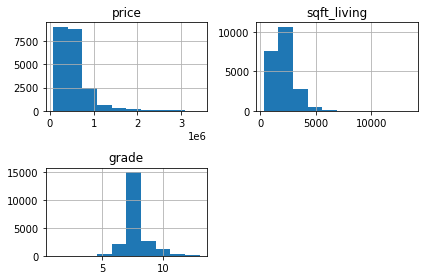

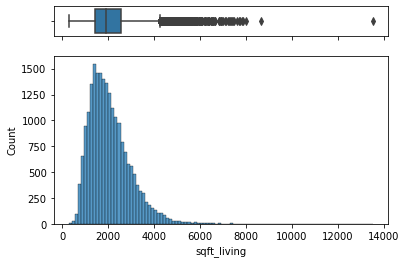

price           2.467258
sqft_living     5.284268
grade          42.926894
dtype: float64
------------------------------
price          217215.240742
sqft_living       392.632695
grade               0.178270
dtype: float64


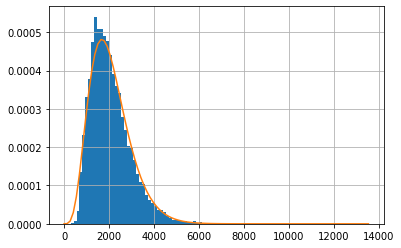

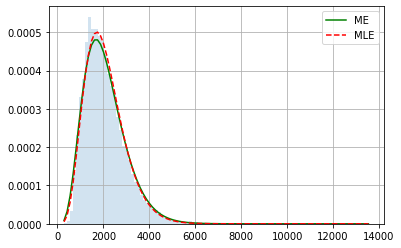

Moments: 5.284267537345997, 392.6326947650373
MLE    : 5.806099490012249, 0.0027984220570314395


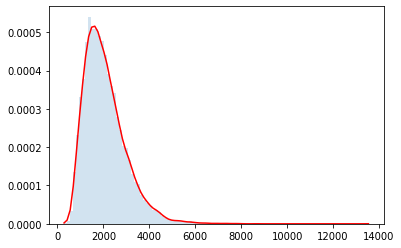

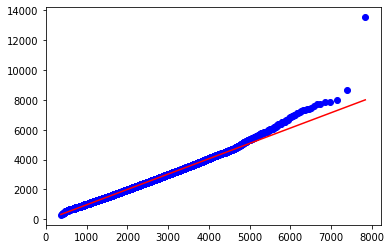

Kalmagorov: Is H1 true? KstestResult(statistic=0.015284290303608117, pvalue=8.22958648464367e-05)
Pearson: Corr coeff (0.9938346666297907, 1.9975176931123557e-95)


In [45]:
_ = dataset[main_variables_labels].hist()
plt.tight_layout()

## Gamma

### Box-and-whiskers diagram

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sbr.boxplot(dataset.sqft_living, ax=ax_box)
sbr.histplot(data=dataset, x="sqft_living", ax=ax_hist, bins=100)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Moments Estimation

alpha = np.mean(dataset[main_variables_labels])**2 / np.var(dataset[main_variables_labels])
beta = np.var(dataset[main_variables_labels]) / np.mean(dataset[main_variables_labels])

print(alpha)
print("-"*30)
print(beta)

_ = dataset.sqft_living.hist(density=True, bins=100)
x = np.linspace(0, np.max(dataset.sqft_living), 100)
_ = plt.plot(x, gamma.pdf(x, alpha.sqft_living, scale=beta.sqft_living))
plt.grid(True)
plt.show()

### Maximum Likelyhood Estimation

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

# Calculate statistics
log_mean = np.log(dataset.sqft_living.mean())
mean_log = dataset.sqft_living.apply(np.log).mean()

# Alpha MLE for December
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean, mean_log))

beta_mle = alpha_mle/dataset.sqft_living.mean()

experimental, buckets = np.histogram(dataset.sqft_living, bins=100, density=True)

dataset.sqft_living.hist(density=True, bins=100, alpha=0.2)
x = np.linspace(0, dataset.sqft_living.max(), 10000)
plt.plot(buckets, gamma.pdf(buckets, alpha.sqft_living, scale=beta.sqft_living), 'g-', label='ME')
plt.plot(buckets, gamma.pdf(buckets, alpha_mle, scale=1/beta_mle), 'r--', label='MLE')

plt.legend(loc='best')

plt.show()

print(f'Moments: {alpha.sqft_living}, {beta.sqft_living}')
print(f'MLE    : {alpha_mle}, {beta_mle}')

### KDE

density_kde = kde.gaussian_kde(dataset.sqft_living)
xgrid = np.linspace(dataset.sqft_living.min(), dataset.sqft_living.max(), 100)
plt.hist(dataset.sqft_living, bins=100, density=True, alpha=0.2)
_ = plt.plot(xgrid, density_kde(xgrid), 'r-')
plt.show()

### QQ plot

import scipy.stats as stats

params = gamma.fit(dataset.sqft_living)

stats.probplot(dataset.sqft_living, dist=gamma, sparams=params , plot=plt)
plt.show()

print( f'Kalmagorov: Is H1 true? {kstest(dataset.sqft_living, gamma.cdf, args=params)}' )

theoretical = gamma.pdf(buckets, *params)


print( f'Pearson: Corr coeff {pearsonr(experimental, theoretical[:-1])}' )

# Grades

/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


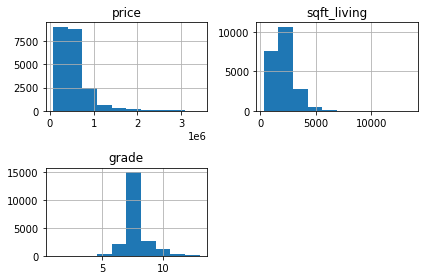

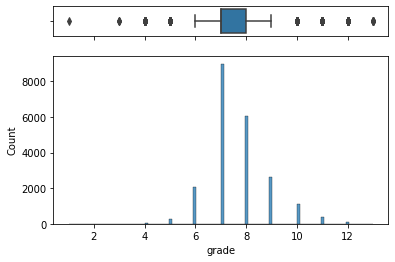

Median: 7
------------------------------
var: 1.3642914789882195


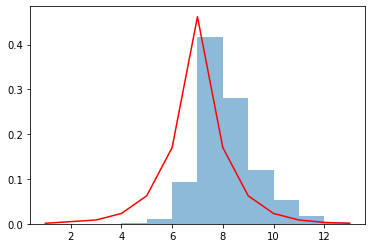

RES:  [1. 7.]


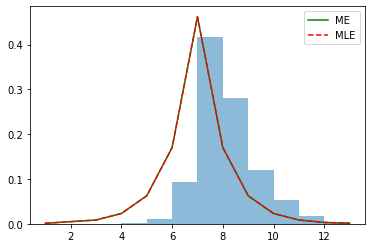

Moments: 7, 1.3642914789882195
MLE    : 7.0, 1.0


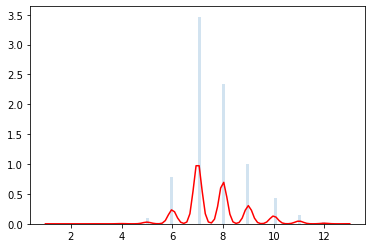

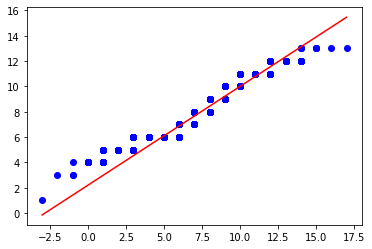

Kalmagorov: Is H1 true? KstestResult(statistic=0.6239306086425102, pvalue=0.0)
Pearson: Corr coeff (0.9267041348059817, 4.11206066815722e-05)


In [46]:
_ = dataset[main_variables_labels].hist()
plt.tight_layout()

## Gamma

### Box-and-whiskers diagram

# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sbr.boxplot(dataset.grade, ax=ax_box)
sbr.histplot(data=dataset, x="grade", ax=ax_hist, bins=100)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

### Moments Estimation

mode = dataset.grade.mode()[0]
var = dataset.grade.var()

print(f'Median: {mode}')
print("-"*30)
print(f'var: {var}')

counts = plt.hist(dataset.grade, bins=np.unique(dataset.grade), density=True, alpha=0.5)
# plt.vlines(np.unique(dataset.bathrooms), 0, buckets, colors='b', lw=5, alpha=0.5)

_ = plt.plot( np.unique(dataset.grade), dlaplace.pmf(np.unique(dataset.grade), 1, loc=mode), 'r-', label='poisson pmf')
# plt.xlim(0, 15)
plt.show()

### Maximum Likelyhood Estimation

dlaplace_like = lambda p, *x: -np.log(dlaplace.pmf(x, p[0], loc=p[1])).sum()

# def dlaplace_like(p, *x):
#     res = -np.log(dlaplace.pmf(x, p[0], loc=p[1])).sum()
#     print(p)
#     print(res)
#    return res

ranges = (slice(1, 20, 1),) * 2
res = brute(dlaplace_like, ranges, disp=True, finish=None, args=dataset.grade)

# res = least_squares(dlaplace_like, [2, 10], args=dataset.grade)
print("RES: ", res)


# dataset.bathrooms.hist(density=True, bins=100, alpha=0.5)
plt.hist(dataset.grade, density=True, bins=np.unique(dataset.grade), alpha=0.5)

x = np.unique(dataset.grade)
plt.plot(x, dlaplace.pmf(x, 1, loc=mode), 'g-', label='ME')
plt.plot(x, dlaplace.pmf(x, res[0], loc=res[1]), 'r--', label='MLE')

plt.legend(loc='best')

plt.show()

print(f'Moments: {mode}, {var}')
print(f'MLE    : {res[1]}, {res[0]}')

### KDE

density_kde = kde.gaussian_kde(dataset.grade)
xgrid = np.linspace(dataset.grade.min(), dataset.grade.max(), 100)
plt.hist(dataset.grade, bins=100, density=True, alpha=0.2)
_ = plt.plot(xgrid, density_kde(xgrid), 'r-')
plt.show()

### QQ plot

import scipy.stats as stats

stats.probplot(dataset.grade, dist=dlaplace, sparams=(res[0], res[1]) , plot=plt)
plt.show()

print( f'Kalmagorov: Is H1 true? {kstest(dataset.grade, dlaplace.cdf, args=(res[0], res[1]))}' )

experimental, buckets = np.histogram(dataset.grade, bins=np.unique(dataset.grade), density=True)
theoretical = dlaplace.pmf(buckets, res[0], res[1])


print( f'Pearson: Corr coeff {pearsonr(experimental, theoretical[:-1])}' )

In [47]:
x = np.linspace(-1, 1, 100)
a = norm.pdf(x)

In [48]:
kstest(a, a)

KstestResult(statistic=0.0, pvalue=1.0)

In [49]:
kstest(a, 'norm')

KstestResult(statistic=0.5955985761504836, pvalue=2.153878415268037e-34)

In [51]:
1.5*np.sqrt((dataset.shape[0] + dataset.shape[0])/(dataset.shape[0]*dataset.shape[0]))

0.01443676470241678

In [54]:
1.22/np.sqrt(dataset.shape[0])

0.008302778498505109